In [15]:
#import the working library
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
%matplotlib inline

In [16]:
#read tickers as specified in excel in addition to market 
all_tickers = pd.read_excel('mapping.xlsx')[['Ticker', 'Market', 'Include']]
#list all tickers
all_tickers = all_tickers[all_tickers['Include']]
all_tickers

,Ticker,Market,Include
0,ARGT,Emerging,True
1,EWA,Developed,True
2,EWO,Developed,True
3,EWK,Developed,True
4,EWZ,Emerging,True
5,EWC,Developed,True
6,ECH,Emerging,True
7,MCHI,Emerging,True
12,EWQ,Developed,True
13,EWG,Developed,True


In [17]:
factor_description = pd.read_excel('factor description.xlsx', index_col='Short Name')
factor_description

,Name,Category
Short Name,,
mom_21,Short-term Absolute Momentum (21-trading day),Technical
mom_63,Medium-term Absolute Momentum (63-trading day),Technical
mom_252,Long-term Absolute Momentum (252-trading day),Technical
mr_21,Percentage over Short-term Moving Average (21-...,Technical
mr_63,Percentage over Medium-term Moving Average (63...,Technical
mr_252,Percentage over Long-term Moving Average (252-...,Technical
div_yield,Dividend Yield,Fundamental
pb,Price/Book Ratio,Fundamental
pe,Price/Earning Ratio,Fundamental


In [1]:
#specified date
start_date_train = '2016-01-01'
end_date_train = '2018-12-31'
start_date_test = '2019-01-01'
end_date_test = '2019-12-31'

# Technical Factors

In [19]:
factors = ['mom_252', 'mom_63', 'mom_21', 
           'mr_252', 'mr_63', 'mr_21']

Long-term Absolute Momentum (252-trading day)


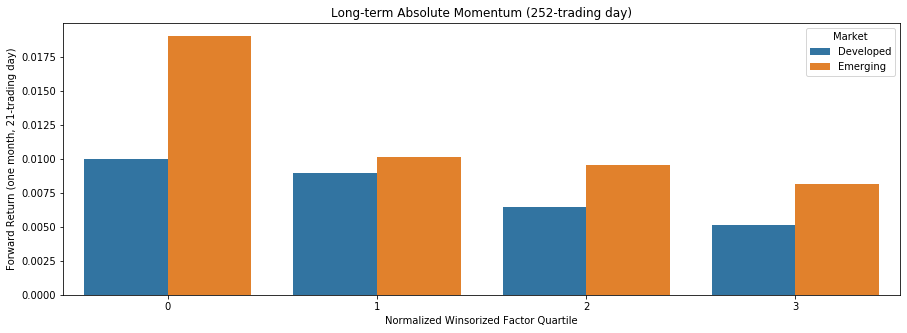

Medium-term Absolute Momentum (63-trading day)


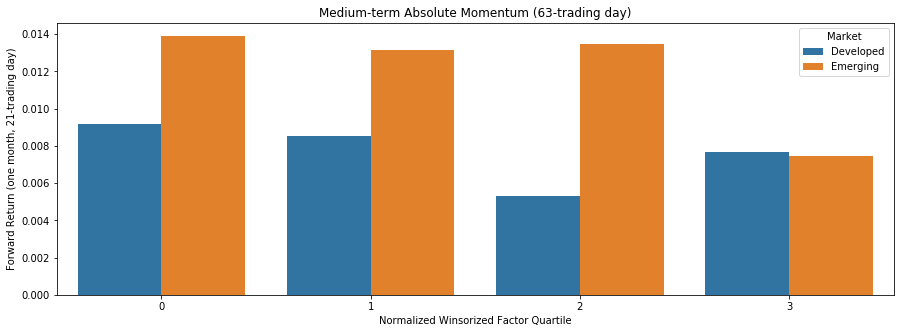

Short-term Absolute Momentum (21-trading day)


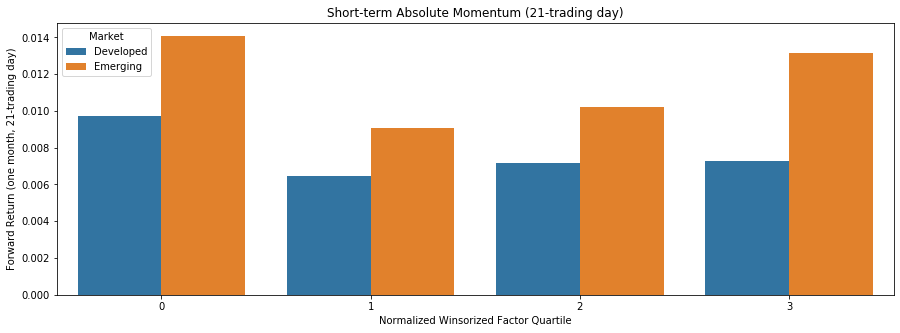

Percentage over Long-term Moving Average (252-trading day)


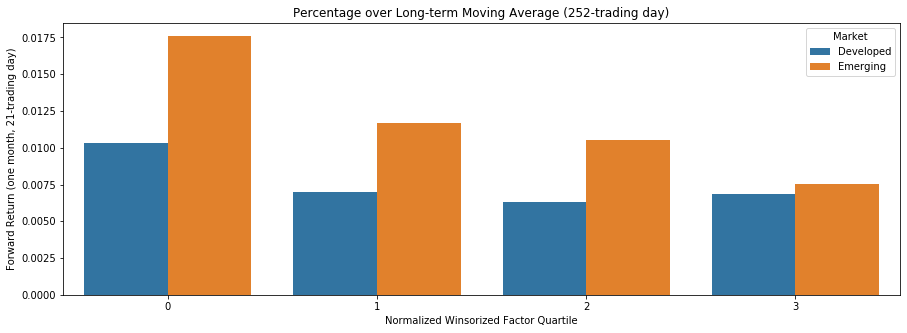

Percentage over Medium-term Moving Average (63-trading day)


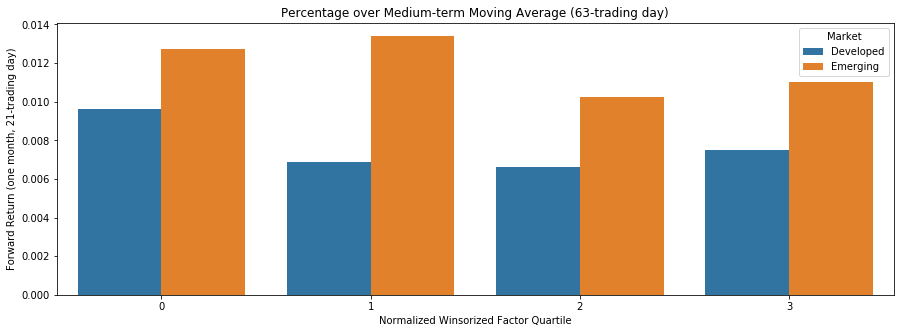

Percentage over Short-term Moving Average (21-trading day)


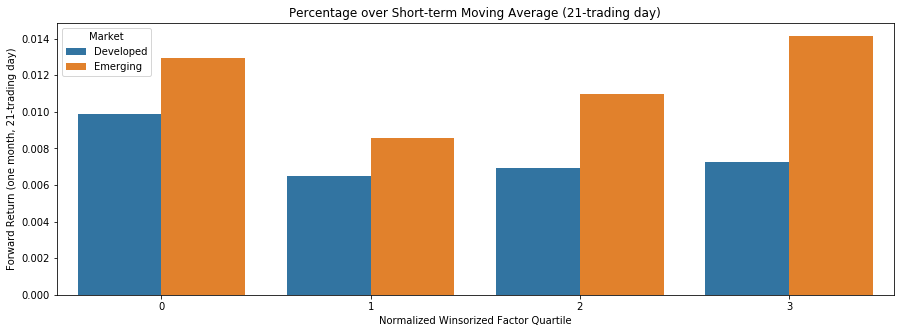

In [20]:
for factor_to_analyze in factors:
    description_factor_to_analyze = factor_description.loc[factor_to_analyze, 'Name']
    print(description_factor_to_analyze)

    #list all etf in datafrome
    all_etf_combined_df = pd.DataFrame()

    #going throw each etf forward return 
    for file in os.listdir('forward return'):
        fr_df = pd.read_csv('forward return/'+file, index_col='Date')
        fr_df['Ticker'] = file[:-4]
        try:
            factor_df = pd.read_csv('factor data/'+factor_to_analyze+'/'+file[:-4]+'.csv', index_col='Date')
            combined_df = fr_df.join(factor_df).rename({factor_to_analyze: 'Factor'}, axis=1)
            combined_df['Factor'] = combined_df['Factor'].fillna(method='ffill')
            all_etf_combined_df = pd.concat([all_etf_combined_df, combined_df.dropna().reset_index()], axis=0, ignore_index=True)
        except:
            continue

    all_etf_combined_df = all_etf_combined_df.join(all_tickers.set_index('Ticker'), on='Ticker').dropna()
    all_etf_combined_df = all_etf_combined_df.sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker'])[start_date_train:end_date_train]
    all_etf_combined_df['Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor Quartile'] = -1

    #combine all factors
    for date in all_etf_combined_df.index.get_level_values(0).unique():
        for market in ['Developed', 'Emerging']:
            n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]
            if n_etf >= 15:
                all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['Factor'], limits=1/n_etf)
            elif n_etf > 0:
                all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = all_etf_combined_df.loc[date].loc[market]['Factor']
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'])
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor Quartile'] = pd.qcut(all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'], 4, labels=False)
    # all_etf_combined_df.loc['2015-01-02'].drop('f_rtn', axis=1)
    #factor quantile study by developed and emerging market
    summary_df = all_etf_combined_df.reset_index().groupby(['Market', 'Normalized Winsorized Factor Quartile']).mean()[['f_rtn']]
    plt.figure(figsize=(15, 5))
    sns.barplot(x='Normalized Winsorized Factor Quartile', 
                y='Forward Return (one month, 21-trading day)', 
                hue='Market', 
                data=summary_df.reset_index().rename(factor_description['Name'].to_dict(), axis=1))
    plt.title(description_factor_to_analyze)
    plt.savefig('factor analysis results/'+factor_to_analyze+'.png')
    plt.show()
    summary_df.rename(factor_description['Name'].to_dict(), axis=1).T.to_excel('factor analysis results/'+factor_to_analyze+'.xlsx')

# Fundamental Factors

In [21]:
factors = ['div_yield', 'pe', 'pb', 'pcf']

Dividend Yield


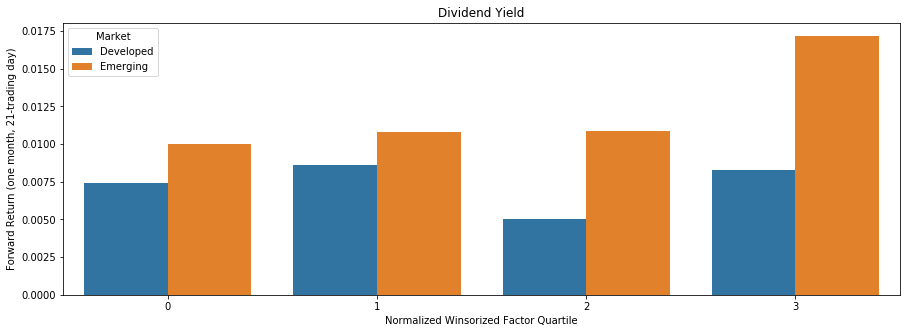

Price/Earning Ratio


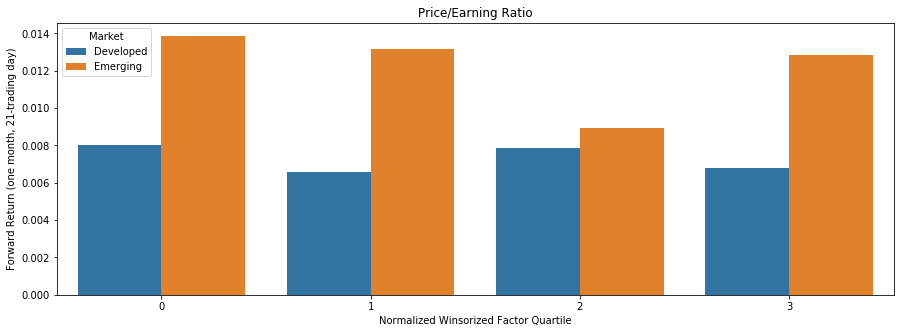

Price/Book Ratio


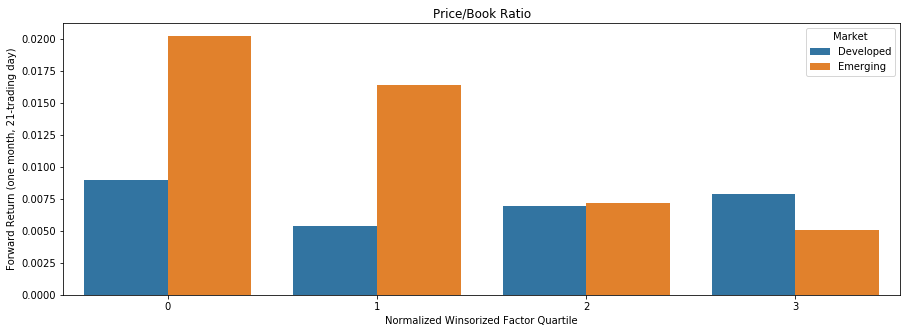

Price/Cash Flow Ratio


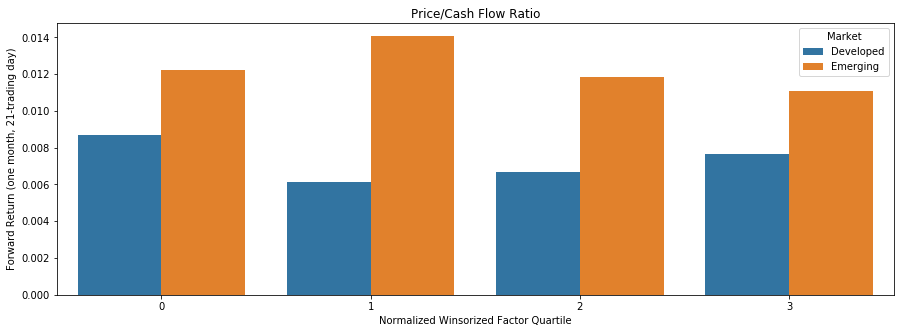

In [22]:
for factor_to_analyze in factors:
    description_factor_to_analyze = factor_description.loc[factor_to_analyze, 'Name']
    print(description_factor_to_analyze)

    #list all etf in datafrome
    all_etf_combined_df = pd.DataFrame()

    #going throw each etf forward return 
    for file in os.listdir('forward return'):
        fr_df = pd.read_csv('forward return/'+file, index_col='Date')
        fr_df['Ticker'] = file[:-4]
        try:
            factor_df = pd.read_csv('factor data/'+factor_to_analyze+'/'+file[:-4]+'.csv', index_col='Date')
            combined_df = fr_df.join(factor_df).rename({factor_to_analyze: 'Factor'}, axis=1)
            combined_df['Factor'] = combined_df['Factor'].fillna(method='ffill')
            all_etf_combined_df = pd.concat([all_etf_combined_df, combined_df.dropna().reset_index()], axis=0, ignore_index=True)
        except:
            continue

    all_etf_combined_df = all_etf_combined_df.join(all_tickers.set_index('Ticker'), on='Ticker').dropna()
    all_etf_combined_df = all_etf_combined_df.sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker'])[start_date_train:end_date_train]
    all_etf_combined_df['Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor Quartile'] = -1

    #combine all factors
    for date in all_etf_combined_df.index.get_level_values(0).unique():
        for market in ['Developed', 'Emerging']:
            if n_etf >= 15:
                all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['Factor'], limits=1/n_etf)
            elif n_etf > 0:
                all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = all_etf_combined_df.loc[date].loc[market]['Factor']
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'])
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor Quartile'] = pd.qcut(all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'], 4, labels=False)
    # all_etf_combined_df.loc['2015-01-02'].drop('f_rtn', axis=1)
    #factor quantile study by developed and emerging market
    summary_df = all_etf_combined_df.reset_index().groupby(['Market', 'Normalized Winsorized Factor Quartile']).mean()[['f_rtn']]
    plt.figure(figsize=(15, 5))
    sns.barplot(x='Normalized Winsorized Factor Quartile', 
                y='Forward Return (one month, 21-trading day)', 
                hue='Market', 
                data=summary_df.reset_index().rename(factor_description['Name'].to_dict(), axis=1))
    plt.title(description_factor_to_analyze)
    plt.savefig('factor analysis results/'+factor_to_analyze+'.png')
    plt.show()
    summary_df.rename(factor_description['Name'].to_dict(), axis=1).T.to_excel('factor analysis results/'+factor_to_analyze+'.xlsx')

# Economic Factors

In [23]:
factors = ['gdp_growth', 'debt_gdp', 'reer']

QoQ GDP Growth


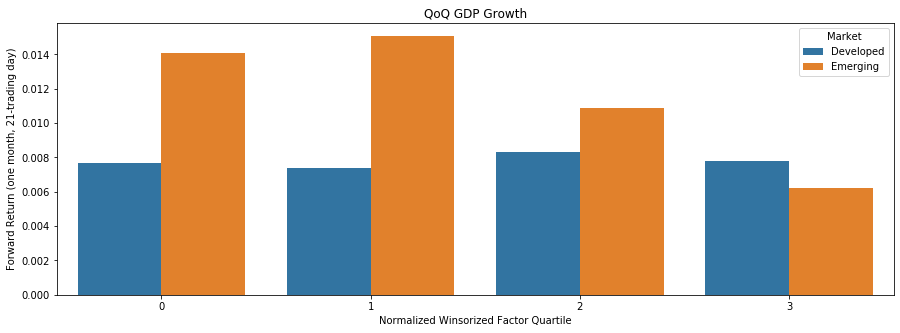

National Debt/GDP Ratio


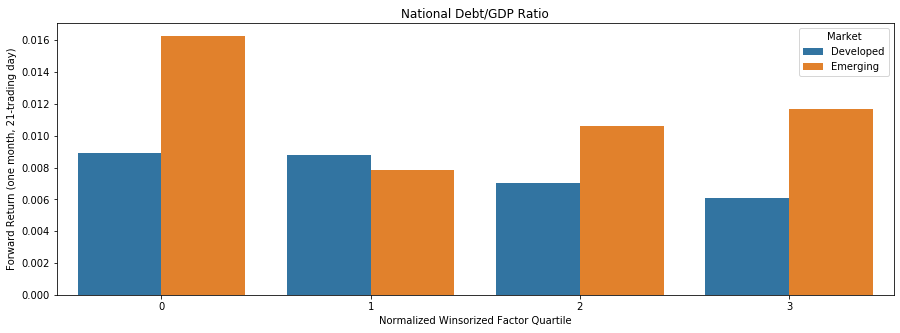

REER


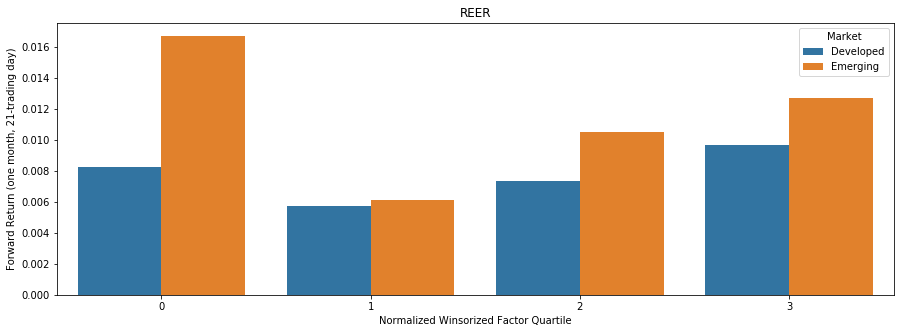

In [24]:
for factor_to_analyze in factors:
    description_factor_to_analyze = factor_description.loc[factor_to_analyze, 'Name']
    print(description_factor_to_analyze)

    #list all etf in datafrome
    all_etf_combined_df = pd.DataFrame()

    #going throw each etf forward return 
    for file in os.listdir('forward return'):
        fr_df = pd.read_csv('forward return/'+file, index_col='Date')
        fr_df['Ticker'] = file[:-4]
        try:
            factor_df = pd.read_csv('factor data/'+factor_to_analyze+'/'+file[:-4]+'.csv', index_col='Date')
            combined_df = fr_df.join(factor_df).rename({factor_to_analyze: 'Factor'}, axis=1)
            combined_df['Factor'] = combined_df['Factor'].fillna(method='ffill')
            all_etf_combined_df = pd.concat([all_etf_combined_df, combined_df.dropna().reset_index()], axis=0, ignore_index=True)
        except:
            continue

    all_etf_combined_df = all_etf_combined_df.join(all_tickers.set_index('Ticker'), on='Ticker').dropna()
    all_etf_combined_df = all_etf_combined_df.sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker'])[start_date_train:end_date_train]
    all_etf_combined_df['Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor Quartile'] = -1

    #combine all factors
    for date in all_etf_combined_df.index.get_level_values(0).unique():
        for market in ['Developed', 'Emerging']:
            n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]
            if n_etf >= 15:
                all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['Factor'], limits=1/n_etf)
            elif n_etf > 0:
                all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = all_etf_combined_df.loc[date].loc[market]['Factor']
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'])
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor Quartile'] = pd.qcut(all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'], 4, labels=False)
    # all_etf_combined_df.loc['2015-01-02'].drop('f_rtn', axis=1)
    #factor quantile study by developed and emerging market
    summary_df = all_etf_combined_df.reset_index().groupby(['Market', 'Normalized Winsorized Factor Quartile']).mean()[['f_rtn']]
    plt.figure(figsize=(15, 5))
    sns.barplot(x='Normalized Winsorized Factor Quartile', 
                y='Forward Return (one month, 21-trading day)', 
                hue='Market', 
                data=summary_df.reset_index().rename(factor_description['Name'].to_dict(), axis=1))
    plt.title(description_factor_to_analyze)
    plt.savefig('factor analysis results/'+factor_to_analyze+'.png')
    plt.show()
    summary_df.rename(factor_description['Name'].to_dict(), axis=1).T.to_excel('factor analysis results/'+factor_to_analyze+'.xlsx')

# Sentimental and Alternative Factors

In [25]:
factors = ['pc_ratio', 'short_int_ratio']

Put/Call Ratio


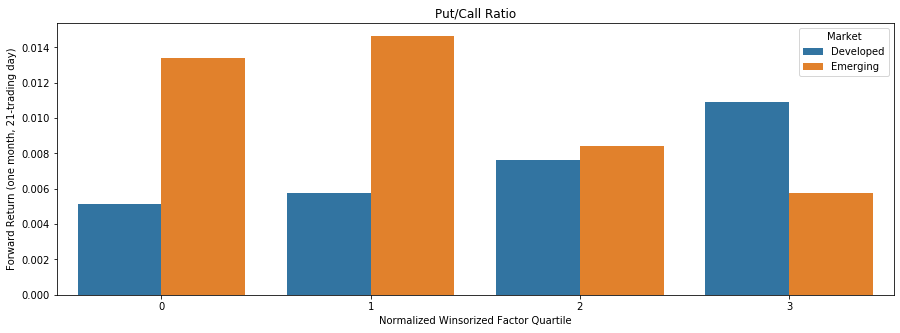

Short Interest/Market Capitalization


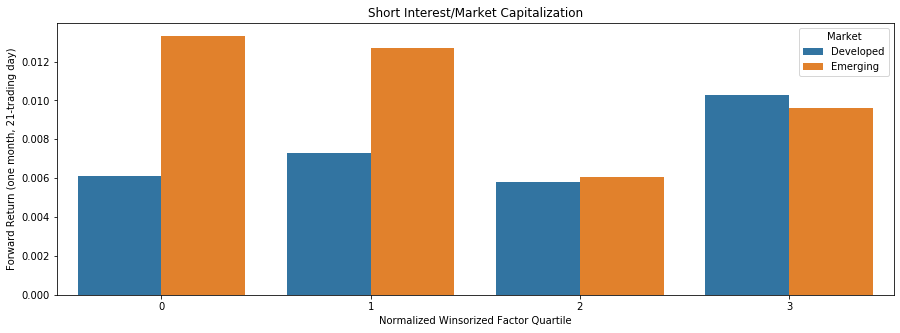

In [26]:
for factor_to_analyze in factors:
    description_factor_to_analyze = factor_description.loc[factor_to_analyze, 'Name']
    print(description_factor_to_analyze)

    #list all etf in datafrome
    all_etf_combined_df = pd.DataFrame()

    #going throw each etf forward return 
    for file in os.listdir('forward return'):
        fr_df = pd.read_csv('forward return/'+file, index_col='Date')
        fr_df['Ticker'] = file[:-4]
        try:
            factor_df = pd.read_csv('factor data/'+factor_to_analyze+'/'+file[:-4]+'.csv', index_col='Date')
            combined_df = fr_df.join(factor_df).rename({factor_to_analyze: 'Factor'}, axis=1)
            combined_df['Factor'] = combined_df['Factor'].fillna(method='ffill')
            all_etf_combined_df = pd.concat([all_etf_combined_df, combined_df.dropna().reset_index()], axis=0, ignore_index=True)
        except:
            continue

    all_etf_combined_df = all_etf_combined_df.join(all_tickers.set_index('Ticker'), on='Ticker').dropna()
    all_etf_combined_df = all_etf_combined_df.sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker'])[start_date_train:end_date_train]
    all_etf_combined_df['Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor Quartile'] = -1

    #combine all factors
    for date in all_etf_combined_df.index.get_level_values(0).unique():
        for market in ['Developed', 'Emerging']:
            n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]
            if n_etf >= 15:
                all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['Factor'], limits=1/n_etf)
            elif n_etf > 0:
                all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = all_etf_combined_df.loc[date].loc[market]['Factor']
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'])
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor Quartile'] = pd.qcut(all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'], 4, labels=False)
    # all_etf_combined_df.loc['2015-01-02'].drop('f_rtn', axis=1)
    #factor quantile study by developed and emerging market
    summary_df = all_etf_combined_df.reset_index().groupby(['Market', 'Normalized Winsorized Factor Quartile']).mean()[['f_rtn']]
    plt.figure(figsize=(15, 5))
    sns.barplot(x='Normalized Winsorized Factor Quartile', 
                y='Forward Return (one month, 21-trading day)', 
                hue='Market', 
                data=summary_df.reset_index().rename(factor_description['Name'].to_dict(), axis=1))
    plt.title(description_factor_to_analyze)
    plt.savefig('factor analysis results/'+factor_to_analyze+'.png')
    plt.show()
    summary_df.rename(factor_description['Name'].to_dict(), axis=1).T.to_excel('factor analysis results/'+factor_to_analyze+'.xlsx')